In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import glob
import itertools
from openpyxl import load_workbook
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import models as md
import log_results as lr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Exploration

In [4]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Simple model example

In [6]:
TT = md.TreeTester(data=data,target='DEATH_EVENT')
TT.evaluate()

In [7]:
results = TT.y_test.to_frame().rename(columns={TT.target: "true_value"})
results['predicted'] = TT.y_pred
cm = confusion_matrix(results.query('index<@TT.original_rows').true_value,results.query('index<@TT.original_rows').predicted)
cm

array([[52, 15],
       [12, 23]])

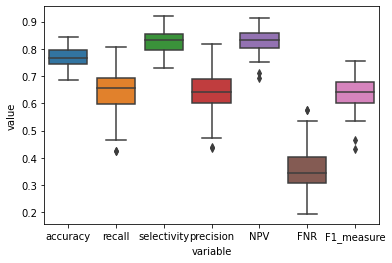

In [8]:
TT.plot_results()

### Running and saving

#### Example: first test config - all features - no oversample - no autotrain

In [13]:
# Look for already existing results dataframes, define "this test number" as "last test number + 1"
test_df_list = glob.glob("results/df/*.pkl")
try:
    test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
except:
    test_no = 0
    
# Test details
features = list(data.drop(['time','DEATH_EVENT'],axis=1).columns)
auto_train = True
added_features = 1
oversample = True
stratify = True
df_name = f'df{test_no}'

# Checking for pre existing resutlts
query = {
    'auto_train': auto_train,
    'added_features': added_features,
    'features': f"{features}",
    'oversample': oversample,
    'stratified': stratify
}
if test_no:
    results_logger = lr.Logger(oversample=oversample,features=features,auto_train=auto_train,
                           added_features=added_features,query=query)
    if len(results_logger.find_row()):
        pass
    else:
        # Running model and saving results
        TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT',oversample=oversample,
                           auto_train=auto_train,added_features=added_features,stratify=stratify)
        TT.evaluate()
        TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

        # Updating test log file
        results_logger = lr.Logger(oversample=oversample,features=features,df_name=df_name,
                                   auto_train=auto_train,added_features=added_features,stratify=stratify,
                                   df_results=TT.evaluators)
        results_logger.update_log()
else:
    TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT',oversample=oversample,
                   auto_train=auto_train,added_features=added_features,stratify=stratify)
    TT.evaluate()
    TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

    # Updating test log file
    results_logger = lr.Logger(oversample=oversample,features=features,df_name=df_name,
                               auto_train=auto_train,added_features=added_features,stratify=stratify,
                               df_results=TT.evaluators)
    results_logger.update_log()

#### Adding more and more and more configurations

In [36]:
# Test details
auto_train = True
added_features = 1
oversample = True
stratify = False

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns,2))):
    # Check if pre-existing results can be found
    query = {
        'auto_train': auto_train,
        'added_features': added_features,
        'features': f"{list(item)}",
        'oversample': oversample,
        'stratified': stratify
    }
    results_logger = lr.Logger(oversample=oversample,features=list(item),auto_train=auto_train,
                               added_features=added_features,query=query)
    if len(results_logger.find_row()):
        pass
    else:
        # Look for already existing results dataframes, define "this test number" as "last test number + 1"
        test_df_list = glob.glob("results/df/*.pkl")
        try:
            test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
        except:
            test_no = 0
        df_name = f'df{test_no}'

        # Running model and saving results
        TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=oversample,
                           auto_train=auto_train,added_features=added_features,stratify=stratify)
        TT.evaluate()
        TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

        # Updating test log file
        results_logger = lr.Logger(oversample=oversample,features=list(item),df_name=df_name,
                                   auto_train=auto_train,added_features=added_features,stratify=stratify,
                                   df_results=TT.evaluators)
        results_logger.update_log()

  0%|          | 0/55 [00:00<?, ?it/s]

#### Force some features to be always in

In [32]:
# Test details
auto_train = True
added_features = 1
oversample = True
stratify = True
forced_features = ['age','sex','smoking']

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT']+forced_features,axis=1).columns,2))):
    query = {
        'auto_train': auto_train,
        'added_features': added_features,
        'features': f"{forced_features+list(item)}",
        'oversample': oversample,
        'stratified': stratify
    }
    results_logger = lr.Logger(oversample=oversample,features=query['features'],auto_train=auto_train,
                               added_features=added_features,query=query)
    if len(results_logger.find_row()):
        pass
    else:
        # Look for already existing results dataframes, define "this test number" as "last test number + 1"
        test_df_list = glob.glob("results/df/*.pkl")
        try:
            test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
        except:
            test_no = 0
        df_name = f'df{test_no}'

        # Running model and saving results
        TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=oversample,
                           auto_train=auto_train,added_features=added_features,stratify=stratify)
        TT.evaluate()
        TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

        # Updating test log file
        results_logger = lr.Logger(oversample=oversample,features=forced_features+list(item),df_name=df_name,
                                   auto_train=auto_train,added_features=added_features,stratify=stratify,
                                   df_results=TT.evaluators)
        results_logger.update_log()

  0%|          | 0/28 [00:00<?, ?it/s]

#### Results dataframe

In [25]:
test_log = pd.read_excel('results/df/test_log.xlsx').drop(['Unnamed: 0'],axis=1)
test_log.round(3).tail(5)

,auto_train,added_features,oversample,features,train_size,stratified,robustness_iterations,results_df,accuracy,recall,selectivity,precision,NPV,FNR,F1_measure
361,False,0,False,"['age', 'sex', 'smoking', 'high_blood_pressure...",0.66,True,100,df361,0.706,0.302,0.899,0.604,0.729,0.698,0.396
362,False,0,False,"['age', 'sex', 'smoking', 'high_blood_pressure...",0.66,True,100,df362,0.658,0.257,0.850,0.454,0.706,0.743,0.321
363,False,0,False,"['age', 'sex', 'smoking', 'platelets', 'serum_...",0.66,True,100,df363,0.620,0.402,0.724,0.410,0.717,0.598,0.404
364,False,0,False,"['age', 'sex', 'smoking', 'platelets', 'serum_...",0.66,True,100,df364,0.588,0.354,0.700,0.363,0.694,0.646,0.356
365,False,0,False,"['age', 'sex', 'smoking', 'serum_creatinine', ...",0.66,True,100,df365,0.674,0.398,0.806,0.501,0.737,0.602,0.439


#### Change number of autotrain routines; fixed features

In [33]:
# Test details
auto_train = True
added_features = [1,2,4,8,16,32]
oversample = True
stratify = True
forced_features = ['ejection_fraction','serum_creatinine']

for n_routines in tqdm(added_features):
    query = {
        'auto_train': auto_train,
        'added_features': n_routines,
        'features': f"{forced_features}",
        'oversample': oversample,
        'stratified': stratify
    }
    results_logger = lr.Logger(oversample=oversample,features=query['features'],auto_train=auto_train,
                               added_features=n_routines,query=query)
    if len(results_logger.find_row()):
        pass
    else:
        # Look for already existing results dataframes, define "this test number" as "last test number + 1"
        test_df_list = glob.glob("results/df/*.pkl")
        try:
            test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
        except:
            test_no = 0
        df_name = f'df{test_no}'

        # Running model and saving results
        TT = md.TreeTester(data=data,features=forced_features,target='DEATH_EVENT',oversample=oversample,
                           auto_train=auto_train,added_features=n_routines,stratify=stratify)
        TT.evaluate()
        TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

        # Updating test log file
        results_logger = lr.Logger(oversample=oversample,features=forced_features,df_name=df_name,
                                   auto_train=auto_train,added_features=n_routines,stratify=stratify,
                                   df_results=TT.evaluators)
        results_logger.update_log()

  0%|          | 0/6 [00:00<?, ?it/s]